# Decathlon Forecast Test 

## Imports

In [117]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from neuralprophet import NeuralProphet

## Data

In [99]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
bu_feat = pd.read_csv("../data/bu_feat.csv")

In [100]:
# datetime dtype can't be specified during reading 
train["day_id"] = pd.to_datetime(train["day_id"])
test["day_id"] = pd.to_datetime(test["day_id"])

In [101]:
train.head()

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443
1,2017-09-30,119,127,1512.995918
2,2017-09-30,4,88,668.593556
3,2017-09-30,425,127,0.000000
4,2017-09-30,513,73,0.000000


In [102]:
bu_feat.head()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10


In [103]:
# add features 
df = train.merge(bu_feat, how="left", on="but_num_business_unit")
df["year"] = df["day_id"].dt.year
df["week_number"] = df["day_id"].dt.isocalendar().week

In [104]:
# check if there is no duplication induced by joins 
len(df) == len(train)

True

In [105]:
df.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,week_number
0,2017-09-30,64,127,580.308443,16400,45.625172,0.111939,70,10,2017,39
1,2017-09-30,119,127,1512.995918,74100,46.195037,6.254448,51,4,2017,39
2,2017-09-30,4,88,668.593556,6600,43.600994,7.078160,55,10,2017,39
3,2017-09-30,425,127,0.000000,59000,50.617921,3.084186,33,3,2017,39
4,2017-09-30,513,73,0.000000,33610,44.717366,-0.733429,33,3,2017,39


## 1. EDA

### 1.a

In [9]:
mask_year_2016 = df["year"] == 2016
top_dpt_2016 = df[mask_year_2016].groupby("dpt_num_department")["turnover"].sum().sort_values(ascending=False).index[0]
print("Dpt with best turnover in 2016: No.", top_dpt_2016)

Dpt with best turnover in 2016: No. 127


### 1.b

In [10]:
mask_year_2015 = df["year"] == 2015
mask_dpt_88 = df["dpt_num_department"] == 88
top_5_weeks_2015_88 = df[mask_year_2015 & mask_dpt_88].groupby("week_number")["turnover"].sum().sort_values(ascending=False).index[:5].to_list()
print("Top 5 weeks with best turnover in 2015 for Dpt No. 88:", top_5_weeks_2015_88)

Top 5 weeks with best turnover in 2015 for Dpt No. 88: [27, 37, 36, 38, 28]


### 1.c

In [11]:
mask_year_2014 = df["year"] == 2014
top_store_2014 = df[mask_year_2014].groupby("but_num_business_unit")["turnover"].sum().sort_values(ascending=False).index[0]
print("Store with best turnover in 2014: No.", top_store_2014)

Store with best turnover in 2014: No. 121


### 1.d

In [12]:
df_73 = df[df["dpt_num_department"] == 73].groupby("day_id")["turnover"].sum().reset_index()

<Axes: xlabel='day_id'>

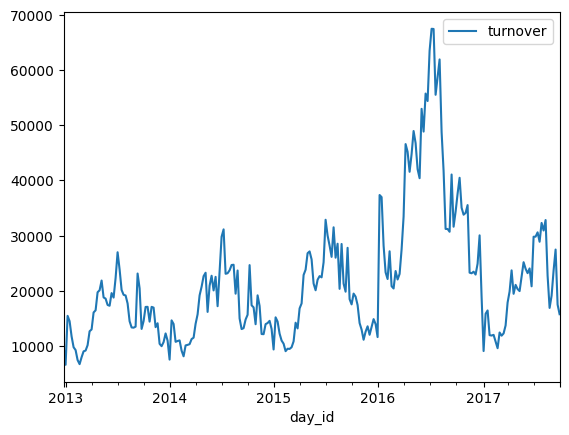

In [13]:
df_73.set_index("day_id").plot()

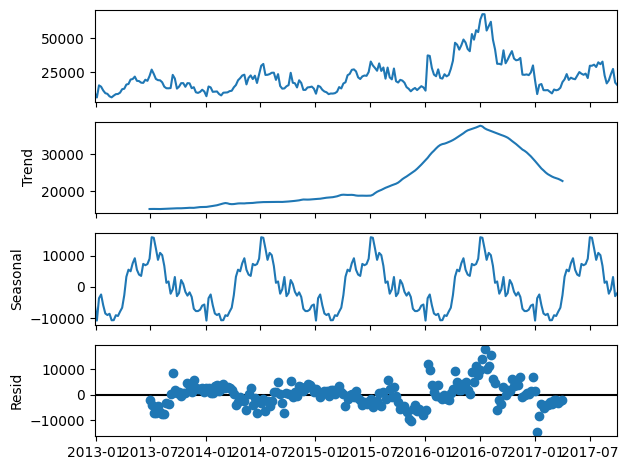

In [14]:
decomp_73 = seasonal_decompose(df_73.set_index("day_id"))
fig = decomp_73.plot()

In [15]:
seasonality_73 = decomp_73.seasonal.reset_index()
seasonality_73["week_nb"] = seasonality_73["day_id"].dt.isocalendar().week
seasonality_73["month"] = seasonality_73["day_id"].dt.month

<Axes: xlabel='week_nb'>

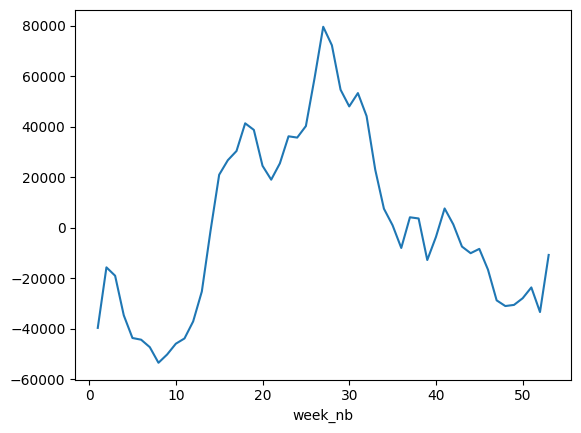

In [16]:
seasonality_73.groupby("week_nb")["seasonal"].sum().plot()

### 1.e

In [17]:
df_117 = df[df["dpt_num_department"] == 117].groupby("day_id")["turnover"].sum().reset_index()

<Axes: xlabel='day_id'>

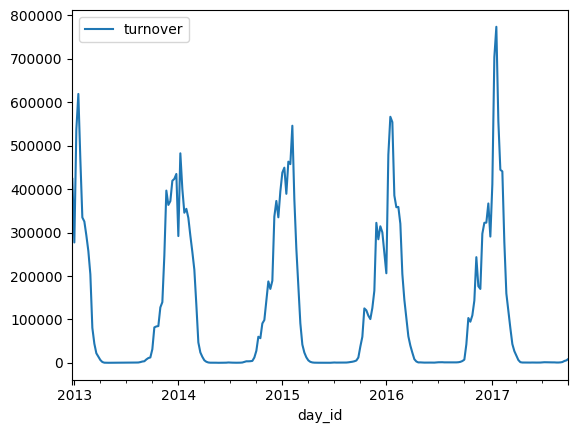

In [18]:
df_117.set_index("day_id").plot()

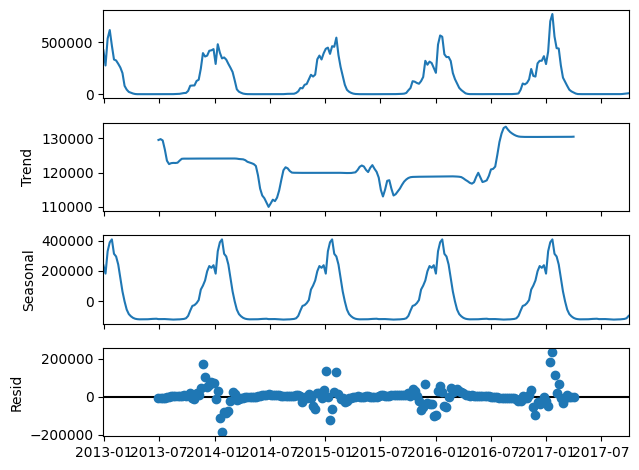

In [19]:
decomp_117 = seasonal_decompose(df_117.set_index("day_id"))
fig = decomp_117.plot()

In [20]:
seasonality_117 = decomp_117.seasonal.reset_index()
seasonality_117["week_nb"] = seasonality_117["day_id"].dt.isocalendar().week
seasonality_117["month"] = seasonality_117["day_id"].dt.month

<Axes: xlabel='week_nb'>

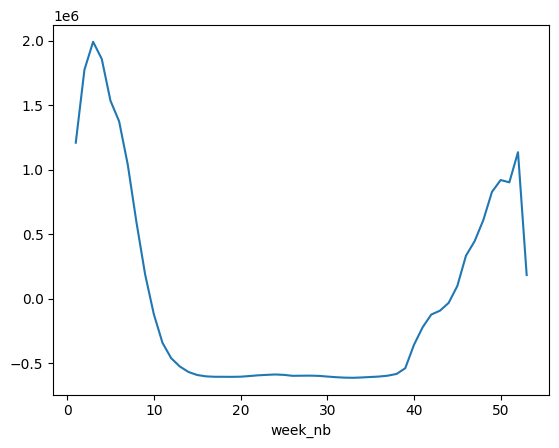

In [21]:
seasonality_117.groupby("week_nb")["seasonal"].sum().plot()

### 1.f

In [22]:
df_bu = df.groupby(bu_feat.columns.to_list())["turnover"].sum().reset_index()

In [23]:
df_bu.head()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,turnover
0,1,59320,50.628060,2.957377,65,4,3.978473e+05
1,2,59960,50.741153,3.134613,65,4,4.046371e+05
2,4,6600,43.600994,7.078160,55,10,1.004336e+06
3,5,83130,43.139162,6.033324,55,10,1.235997e+06
4,6,76360,49.527580,0.964279,30,6,6.188135e+05


In [24]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(
    df_bu,
    lat="but_latitude",
    lon="but_longitude",
    hover_name="but_num_business_unit",
    color="zod_idr_zone_dgr",
    color_continuous_scale=color_scale,
    size="turnover",
    zoom=5, 
    height=800,
    width=800,
    center={"lat":46.606111, "lon":1.875278}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":10,"l":10,"b":10})
fig.show()

<Axes: xlabel='zod_idr_zone_dgr'>

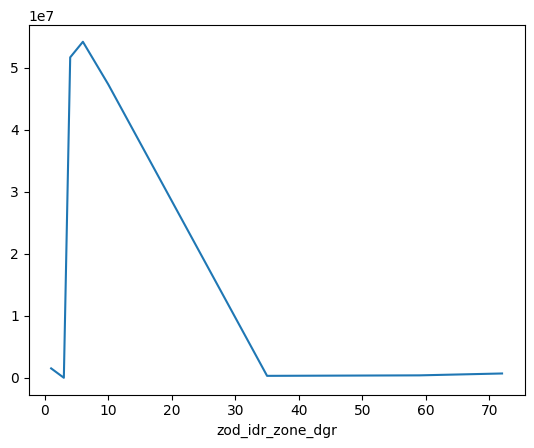

In [25]:
df.groupby("zod_idr_zone_dgr")["turnover"].sum().plot()

<Axes: xlabel='day_id'>

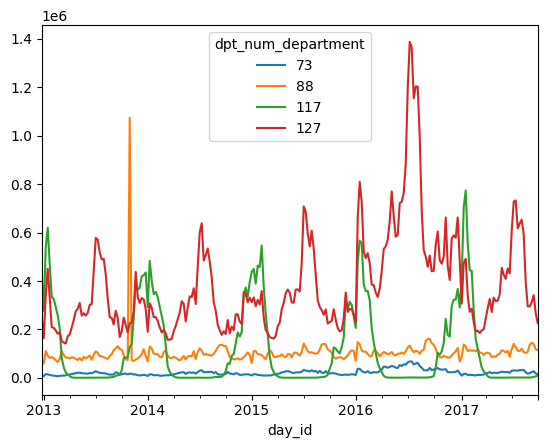

In [26]:
df.groupby(["day_id", "dpt_num_department"])["turnover"].sum().unstack().plot()

## 2. Modeling

In [27]:
df

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,week_number
0,2017-09-30,64,127,580.308443,16400,45.625172,0.111939,70,10,2017,39
1,2017-09-30,119,127,1512.995918,74100,46.195037,6.254448,51,4,2017,39
2,2017-09-30,4,88,668.593556,6600,43.600994,7.078160,55,10,2017,39
3,2017-09-30,425,127,0.000000,59000,50.617921,3.084186,33,3,2017,39
4,2017-09-30,513,73,0.000000,33610,44.717366,-0.733429,33,3,2017,39
...,...,...,...,...,...,...,...,...,...,...,...
277714,2012-12-29,131,73,1.461821,69760,45.822363,4.767741,8,4,2012,52
277715,2012-12-29,237,127,759.283046,13500,43.430995,5.047929,71,10,2012,52
277716,2012-12-29,129,117,1716.399152,14124,49.154936,-0.287441,30,6,2012,52
277717,2012-12-29,468,127,1307.357057,94320,48.757857,2.385381,75,6,2012,52


In [28]:
df = df.rename(columns={"day_id":"ds", "turnover":"y"})

In [29]:
df["ID"] = df["but_num_business_unit"].astype(str) + "_" + df["dpt_num_department"].astype(str)

In [30]:
df_mv = df.groupby(["ds", "ID"])["y"].sum().reset_index()
df_mv.head()

,ds,ID,y
0,2012-12-29,100_117,3736.141601
1,2012-12-29,100_127,2082.464788
2,2012-12-29,100_73,334.798246
3,2012-12-29,100_88,744.595088
4,2012-12-29,109_117,551.019581


<Axes: xlabel='ID'>

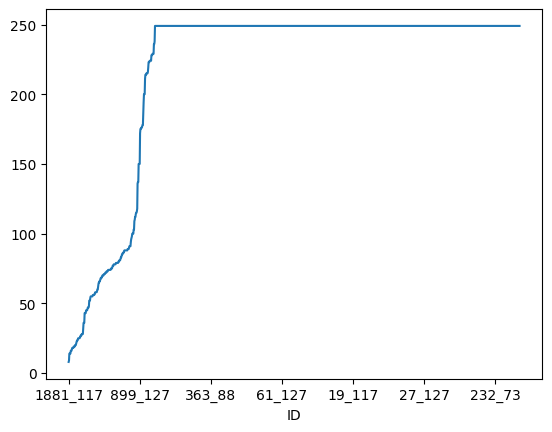

In [33]:
df_mv.groupby("ID")["ds"].count().sort_values().plot()

In [34]:
g = df_mv.groupby("ID")["ds"].count().reset_index()
keep = g[g["ds"] == 249]["ID"].to_list()

In [35]:
df_mv_f = df_mv[df_mv["ID"].isin(keep)].reset_index(drop=True)

In [ ]:
m = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    unknown_data_normalization=True
)
m.fit(df_mv_f)

In [106]:
df_test = test.copy()

In [107]:
df_test["ID"] = df_test["but_num_business_unit"].astype(str) + "_" + df_test["dpt_num_department"].astype(str)

In [108]:
df_test = df_test[["day_id", "ID"]]
df_test.columns = ["ds", "ID"]

In [109]:
pd.concat([df_mv, df_test])

,ds,ID,y
0,2012-12-29,100_117,3736.141601
1,2012-12-29,100_127,2082.464788
2,2012-12-29,100_73,334.798246
3,2012-12-29,100_88,744.595088
4,2012-12-29,109_117,551.019581
...,...,...,...
10131,2017-10-07,61_88,NaN
10132,2017-10-07,641_117,NaN
10133,2017-10-07,724_117,NaN
10134,2017-10-07,1302_117,NaN


In [ ]:
forecast = m.predict(pd.concat([df_mv_f, df_test_f]))

<Axes: xlabel='ds'>

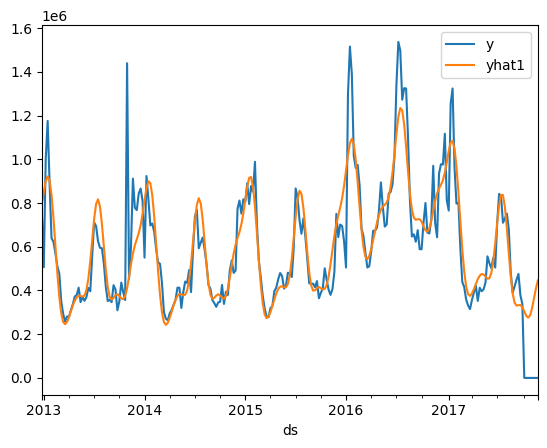

In [47]:
global_forecast = forecast.groupby("ds")[["y", "yhat1"]].sum().reset_index()
global_forecast.set_index("ds").plot()